In [1]:
%reset -f
%load_ext autoreload
%autoreload 2
import numpy as np
seed=190
np.random.seed(seed)

In [ ]:
!python 'data/data.py'

In [ ]:
from data.data import credit
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
plot=sns.PairGrid(credit,hue='Sex',vars=['Age','Credit amount','Duration'],palette={'red','gray'})
plot.map_upper(sns.scatterplot,size=credit['Default'],alpha=0.2,markers=True)
plot.map_lower(sns.kdeplot,fill=False,alpha=0.5,shade=True)
plot.map_diag(sns.histplot,kde=True,alpha=0.5)
plot.add_legend()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.boxplot(data=credit,x='Sex',y='Credit amount',linewidth=2.5,palette="Set2",ax=ax[0]).set_title("Credit amount Distribution with Sex")
sns.boxplot(data=credit,x='Sex',y='Duration',linewidth=2.5,palette="Set2",ax=ax[1]).set_title("Repayment duration Distribution with Sex")

In [ ]:
!python loaders/features.py

### Pyro --------------------------------------------- Essentials----

In [ ]:
import pyro
import torch
import pyro.distributions as dist

In [ ]:
def model(x):
    s = pyro.param("s", torch.tensor(0.5))
    z = pyro.sample("z", dist.Normal(x, s))
    return z ** 2

In [ ]:
pyro.sample("z",dist.Normal(3, 1), obs=[torch.tensor([0]),torch.tensor([1])])

In [ ]:
model(2)

In [ ]:
trace = pyro.poutine.trace(model).get_trace(145.0)


In [ ]:
print(trace.nodes)

In [ ]:
list(name for name in trace.nodes.keys()) 

In [ ]:
trace.log_prob_sum()

In [ ]:
from torch.distributions import Independent


for name, node in trace.nodes.items():
    if 'fn' not in node.keys():
        print(name,'----',node)
    else:
        #print('-----',name,node['fn'])
        fn=node['fn']
        if isinstance(fn, Independent):
            print('Independent')

### Trial -------
---

In [ ]:
from loaders.features import get_features_dataset
x=get_features_dataset('german_credit_data.csv',inference=True)
from models.nfs import conditionalscm    

In [ ]:
scm=conditionalscm(flow_dict=x.flow_dict).cuda()
print(scm.model())

In [ ]:
print(scm.sample())

In [ ]:
import torch
data = {'amount': torch.multiply(torch.rand((2)),torch.tensor([10000])).reshape(-1,1).float().cuda(), 'sex': torch.tensor([[1],[0]]).float().cuda(), 'age': torch.tensor([[50],[25]]).float().cuda(), 'duration': torch.tensor([[20],[15]]).float().cuda()} 
        #'risk': torch.tensor([1]).float().cuda()}

print(data)

In [ ]:
print(scm.infer_exogeneous(**data))

In [ ]:
cdn=  { 'do(sex=Female)': {'sex': torch.zeros_like(data['sex'])},
        'do(sex=Male)': {'sex': torch.ones_like(data['sex']) * 1}}
condition=cdn['do(sex=Female)']
condition['age']=torch.tensor([[2.0],[4.0]]).cuda()
print(condition,type(condition))
print(scm.counterfactual(obs=data,condition=condition))

### Trial -2 
---

In [ ]:
import torch
obs=torch.rand(10)
print(obs.tolist())

In [ ]:
from sklearn.preprocessing import LabelEncoder
c= LabelEncoder()
c.fit(obs.tolist())
cla = len(c.classes_)
covariates_dict = {'sex': c}
print(cla)

In [ ]:
from collections import Counter
from torch.distributions.utils import probs_to_logits
observation = c.transform(obs.tolist())
obs_counts = Counter(observation)
obs_mass = [v/sum(obs_counts.values()) for k,v in obs_counts.items()]
obs_logits = probs_to_logits(torch.as_tensor(obs_mass), is_binary=False)
print('mass:',obs_mass,'\n logits:',obs_logits.reshape(1,-1))

In [ ]:
from pyro.distributions import  Categorical
dist=Categorical(logits=torch.nn.Parameter(obs_logits))

In [ ]:
import pyro
pyro.sample('obs', dist,obs=2)


### Training-Testing
---

In [ ]:
!python train.py --batch-size 64 --gpu-id 0 --epochs 5 \
  --data-filename 'german_credit_data.csv'\
  --dim 1 \
  --flow-type 'affine'\
  --flow-order 'linear'

In [ ]:
!python infer.py --batch-size 64 --gpu-id 0 \
  --data-filename 'german_credit_data.csv'\
  --dim 1 \
  --flow-type 'affine'  \
  --flow-order 'linear'\
  --condition 'do(sex=Male)'

### Miscellaneous
--------------
---

In [ ]:
torch.tensor([2.5]).cuda()

In [ ]:
import torch.nn.functional as F
import torch
logits = torch.randn(2, 3)
print(logits)

In [ ]:
F.gumbel_softmax(logits, tau=1, hard=True)

In [ ]:
import pyro
from pyro.distributions import Normal, Bernoulli, Categorical, TransformedDistribution, Uniform, RelaxedBernoulliStraightThrough
pyro.sample('z', RelaxedBernoulliStraightThrough(temperature=torch.tensor(0.05), probs=torch.tensor([0.4])).log_prob(torch.tensor([[1.0]])))

In [ ]:
torch.tensor([4,5,6,8,9]).reshape([-1,1])

In [ ]:
import torch
from pyro.nn import DenseNN
input_dim = 10
context_dim = 5
z = torch.rand(100, context_dim)
nn = DenseNN(context_dim, [50], param_dims=[1, input_dim, input_dim])
a, b, c = nn(z) 
print(nn)

In [ ]:
print(a.shape,b.shape,c.shape)

In [ ]:
dense=DenseNN(2, [8,16], param_dims=[1, 1], nonlinearity=torch.nn.LeakyReLU(.1))
print(dense)

In [ ]:
loc, log_scale = dense()

## Path Dependent Flow
---

In [ ]:
from loaders.features import get_features_dataset
x=get_features_dataset('german_credit_data.csv',inference=True)
from models.nfs_path import conditionalscm_path 

In [ ]:
scm=conditionalscm_path(flow_dict=x.flow_dict).cuda()
print(scm.pgm_model())

In [ ]:
print(scm.sample())

In [ ]:
import torch
data = {'amount': torch.multiply(torch.rand((2)),torch.tensor([10000])).reshape(-1,1).float().cuda(), 'sex': torch.tensor([[1],[0]]).float().cuda(), 'age': torch.tensor([[50],[25]]).float().cuda(), 'duration': torch.tensor([[20],[15]]).float().cuda()} 
        #'risk': torch.tensor([1]).float().cuda()}

print(data)

In [ ]:
print(scm.infer_exogeneous(**data))

In [ ]:
cdn=  { 'do(sex=Female)': {'sex': torch.zeros_like(data['sex'])},
        'do(sex=Male)': {'sex': torch.ones_like(data['sex']) * 1}}
condition=cdn['do(sex=Female)']
#print(condition)
print(scm.counterfactual(obs=data,condition=condition))

---

In [ ]:
import pyro
import torch
from pyro.distributions import Normal

x=pyro.sample('age', Normal(0,1),obs=None)


In [ ]:
torch.tensor([x])

In [ ]:
sex tensor([[1]], device='cuda:0')
age tensor([0.2983]

### Training-Testing

In [ ]:
import models
from loaders.features import get_features_dataset
x=get_features_dataset('german_credit_data.csv',inference=True)

In [ ]:
model = models.__dict__['conditionalscm_path'](
    flow_dict=x.flow_dict, flow_type='affine', order='linear')

In [ ]:
print(model)

### Training
----

In [ ]:
!python train.py --batch-size 64 --gpu-id 0 --epochs 100 \
  --data-filename 'german_credit_data.csv'\
  --dim 1 \
  --flow-type 'spline'\
  --flow-order 'quadratic'\
  --arch 'conditionalscm_path'

### Inference 
----

In [ ]:
!python infer.py --batch-size 64 --gpu-id 0 \
  --data-filename 'german_credit_data.csv'\
  --dim 1 \
  --flow-type 'spline'  \
  --flow-order 'quadratic'\
  --condition 'do(sex=Male)'\
  --arch 'conditionalscm_path'

### Plots and Visualizations
---

In [2]:
import os
directory = 'datasets/counterfactuals'
 
# iterate over files in
# that directory
dictionary_full={}
dictionary_partial={}
index_full=0
index_partial=0

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        g=f.split('/')[-1].split('.')[0].split('_')
        key={'path':f,'flowtype':g[-6],'floworder':g[-4],'intervention':  g[-3]+'('+g[-2]+'='+g[-1]+')'}
        if g[1]=='path':
            model='partial'
            key['model']=model
            dictionary_partial[index_partial]=key
            index_partial=index_partial+1
        else:
            model='full'
            key['model']=model
            dictionary_full[index_full]=key
            index_full=index_full+1

item=[]
for i in range(12):
    for j in range(12):
        if dictionary_full[i]['flowtype']==dictionary_partial[j]['flowtype']:
            if dictionary_full[i]['floworder']==dictionary_partial[j]['floworder'] :
                if dictionary_full[i]['intervention']==dictionary_partial[j]['intervention']:
                    item.append((i,j))

item_full=[]                
for i in range(12):
    for j in range(12):
        if dictionary_full[i]['flowtype']==dictionary_full[j]['flowtype']:
            if dictionary_full[i]['floworder']==dictionary_full[j]['floworder'] :
                if dictionary_full[i]['intervention']!=dictionary_full[j]['intervention']:
                    item_full.append((i,j))



item_full_updated=[]

for(i,j) in item_full:
    if (j,i) in item_full and i<j:
        item_full_updated.append((i,j))
item_full=item_full_updated
        
flow_combinations=[]
for (i,j) in item:
    for (k,l) in item_full:
        if i==k :
            m=[t for (s,t) in item if s == l][0]
            flow_combinations.append([(i,j),(l,m)])
            
print(flow_combinations)


[[(0, 2), (2, 7)], [(1, 6), (9, 5)], [(3, 8), (10, 4)], [(4, 10), (7, 3)], [(5, 1), (8, 9)], [(6, 0), (11, 11)]]


      Index     Sex   Age  Credit amount  Duration     model  Default value
0         0  female  67.0         1203.0       6.0   partial  Default  good
1         2  female  49.0         2178.0      12.0   partial  Default  good
2         3  female  45.0         8425.0      42.0   partial  Default  good
3         4  female  53.0         5158.0      24.0   partial  Default   bad
4         5  female  35.0         9692.0      36.0   partial  Default  good
...     ...     ...   ...            ...       ...       ...      ...   ...
2065    994    male  50.0         2390.0      12.0  observed  Default  good
2066    996    male  40.0         3857.0      30.0  observed  Default  good
2067    997    male  38.0          804.0      12.0  observed  Default  good
2068    998    male  23.0         1845.0      45.0  observed  Default   bad
2069    999    male  27.0         4576.0      45.0  observed  Default  good

[2070 rows x 8 columns]
     Index     Sex   Age  Credit amount  Duration     model  De

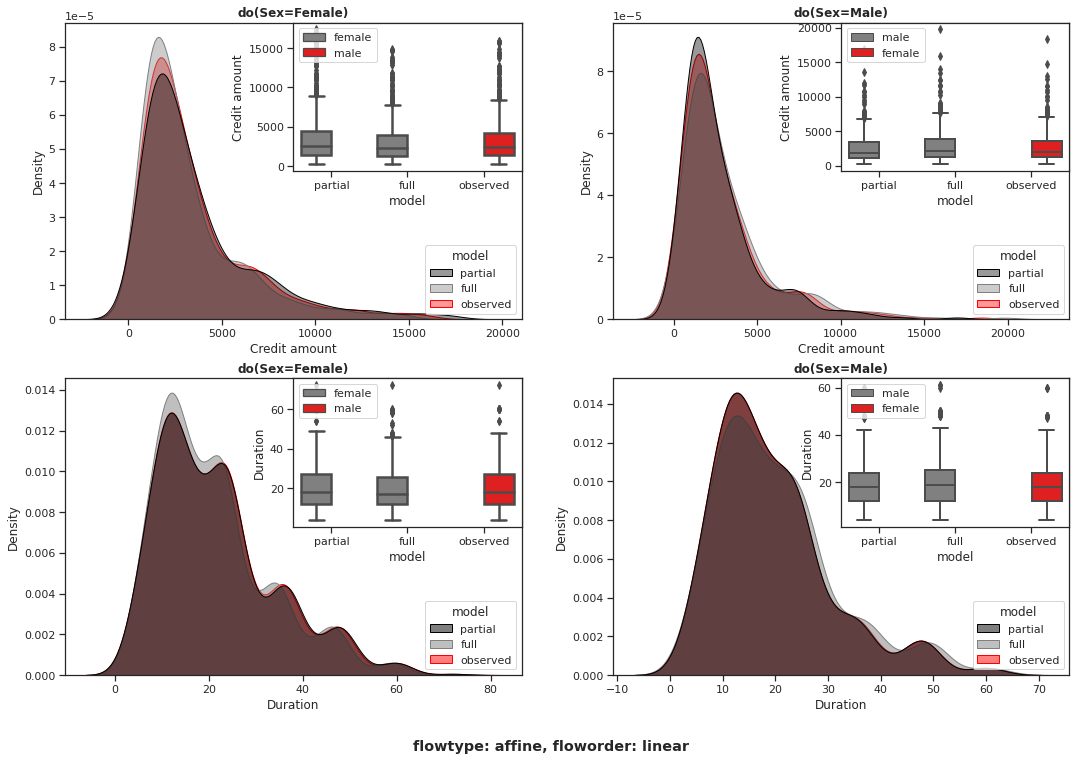

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_file(path):
    credit=pd.read_csv(path)
    credit=credit=pd.DataFrame(data=credit, columns=["Index","Sex", "Age","Credit amount","Duration","Default"])
    return credit



    
def plot_function(flow_combination):
    [(k,l),(m,n)]=flow_combination
    #print(k,l,m,n)
    k=dictionary_full[k]
    l=dictionary_partial[l]
    m=dictionary_full[m]
    n=dictionary_partial[n]
    
    if k['flowtype']==l['flowtype']==m['flowtype']==n['flowtype']:
        flowtype=k['flowtype']
    #print(flowtype)
    
    if k['floworder']==l['floworder']==m['floworder']==n['floworder']:
        floworder=k['floworder']
    #print(floworder)
    
    
    x_k=[k,read_file(k['path']).assign(model=k['model'])]
    x_l=[l,read_file(l['path']).assign(model=l['model'])]
    x_m=[m,read_file(m['path']).assign(model=m['model'])]
    x_n=[n,read_file(n['path']).assign(model=n['model'])]
    default=read_file('data/german_credit_data.csv').assign(model='observed')
    
    do_sex_male=[]
    do_sex_female=[]
    for i in [x_k,x_l,x_m,x_n]:
        if i[0]['intervention']=='do(sex=Female)':
               do_sex_female.append(i[1])
        if i[0]['intervention']=='do(sex=Male)':
            do_sex_male.append(i[1])
            
                
    default_male=default.loc[default['Sex']=='male']

    do_sex_male[1]= do_sex_male[1].loc[default['Sex']=='female']
    do_sex_male[0]= do_sex_male[0].loc[default['Sex']=='female']
    default_female=default.loc[default['Sex']=='female']
    
    
    do_sex_female[1]= do_sex_female[1].loc[default['Sex']=='male']
    do_sex_female[0]= do_sex_female[0].loc[default['Sex']=='male']
    default_male=default.loc[default['Sex']=='male']
    
    did_sex_female = pd.concat([ do_sex_female[1], do_sex_female[0],default_male])    
    do_sex_female = pd.melt(did_sex_female, id_vars=["Index",'Sex', "Age","Credit amount","Duration",'model'],var_name=['Default'])
    print(do_sex_female)
    
    did_sex_male = pd.concat([ do_sex_male[1], do_sex_male[0],default_female])    
    do_sex_male = pd.melt(did_sex_male, id_vars=["Index",'Sex', "Age","Credit amount","Duration",'model'],var_name=['Default'])
    print(do_sex_male)
    
    sns.set(style="ticks")
    
    fig, ax = plt.subplots(2,2, figsize=(18,12))
    sns.kdeplot(data=do_sex_female,x='Credit amount',hue='model',palette={'red','black','gray'},ax=ax[0][0],fill=True,alpha=0.4,legend=True).set_title("do(Sex=Female)",fontweight='bold')
    sns.move_legend(ax[0][0],loc='lower right')
    sns.kdeplot(data=do_sex_female,x='Duration',hue='model',ax=ax[1][0],palette={'red','black','gray'},fill=True,alpha=0.5,legend=True).set_title("do(Sex=Female)",fontweight='bold')
    sns.move_legend(ax[1][0],loc='lower right')
    ax_inside=ax[0][0].inset_axes([0.5,0.5,0.5,0.5])
    ax_inside_1=ax[1][0].inset_axes([0.5,0.5,0.5,0.5])
    sns.boxplot(data=do_sex_female,x='model',y='Credit amount',hue='Sex' ,palette={'red','gray'},linewidth=2.5,ax=ax_inside)
    ax_inside.legend(loc='upper left')
    sns.boxplot(data=do_sex_female,x='model',y='Duration',hue='Sex',palette={'red','gray'},linewidth=2.5,ax=ax_inside_1)
    ax_inside_1.legend(loc='upper left')
    
    sns.kdeplot(data=do_sex_male,x='Credit amount',hue='model',ax=ax[0][1],fill=True,palette={'red','gray','black'},alpha=0.4,legend=True).set_title("do(Sex=Male)",fontweight='bold')
    sns.move_legend(ax[0][1],loc='lower right')
    sns.kdeplot(data=do_sex_male,x='Duration',hue='model',ax=ax[1][1],fill=True,palette={'red','black','gray'},alpha=0.5,legend=True).set_title("do(Sex=Male)",fontweight='bold')
    sns.move_legend(ax[1][1],loc='lower right')
    ax_inside_2=ax[0][1].inset_axes([0.5,0.5,0.5,0.5])
    ax_inside_3=ax[1][1].inset_axes([0.5,0.5,0.5,0.5])
    sns.boxplot(data=do_sex_male,x='model',y='Credit amount',hue='Sex',palette={'red','gray'},linewidth=2,ax=ax_inside_2)
    ax_inside_2.legend(loc='upper left')
    sns.boxplot(data=do_sex_male,x='model',y='Duration',hue='Sex',palette={'red','gray'},linewidth=2,ax=ax_inside_3)
    ax_inside_3.legend(loc='upper left')
    fig.suptitle('flowtype: '+flowtype+', floworder: '+floworder,y=0.05,fontweight='bold' )
    
    return fig, flowtype,floworder
    
        
x=plot_function(flow_combinations[0])   

def save_png(x):
    directory='assets/plots'
    if not os.path.exists(directory):
        os.mkdir(directory)
    x[0].savefig(os.path.join(directory,x[1]+"_"+x[2]+'.pdf'), format='pdf',dpi=1200)
    


      Index     Sex   Age  Credit amount  Duration     model  Default value
0         0  female  67.0         1203.0       6.0   partial  Default  good
1         2  female  49.0         2178.0      12.0   partial  Default  good
2         3  female  45.0         8425.0      42.0   partial  Default  good
3         4  female  53.0         5158.0      24.0   partial  Default   bad
4         5  female  35.0         9692.0      36.0   partial  Default  good
...     ...     ...   ...            ...       ...       ...      ...   ...
2065    994    male  50.0         2390.0      12.0  observed  Default  good
2066    996    male  40.0         3857.0      30.0  observed  Default  good
2067    997    male  38.0          804.0      12.0  observed  Default  good
2068    998    male  23.0         1845.0      45.0  observed  Default   bad
2069    999    male  27.0         4576.0      45.0  observed  Default  good

[2070 rows x 8 columns]
     Index     Sex   Age  Credit amount  Duration     model  De

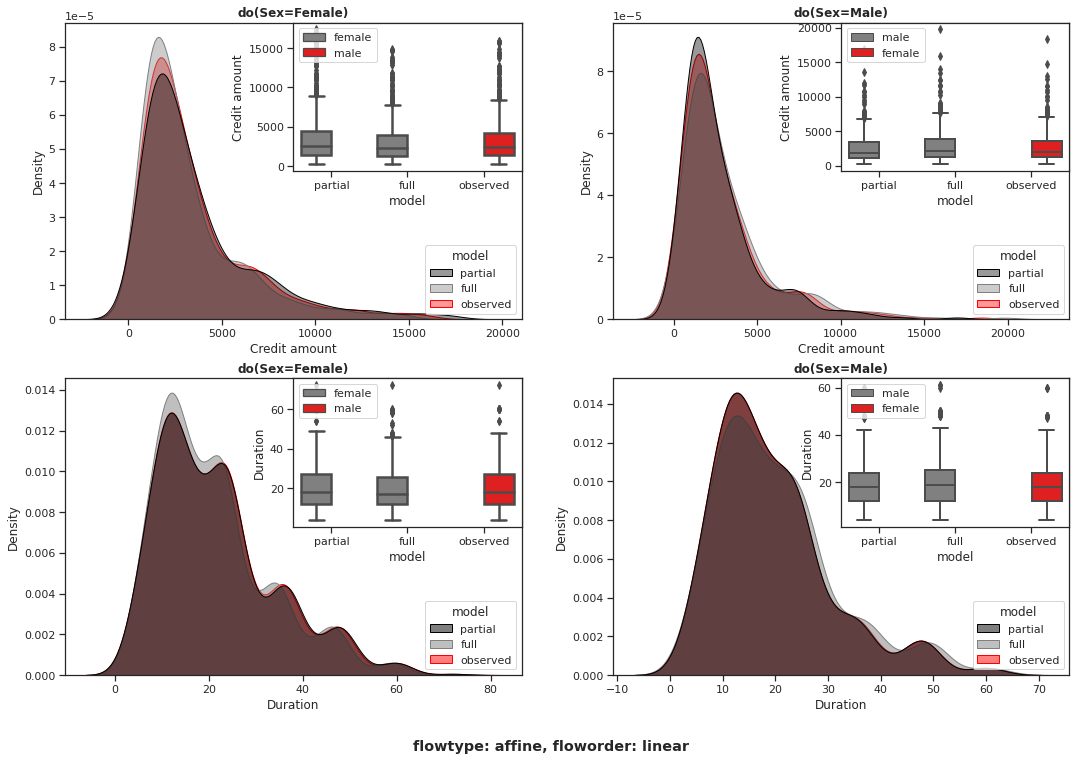

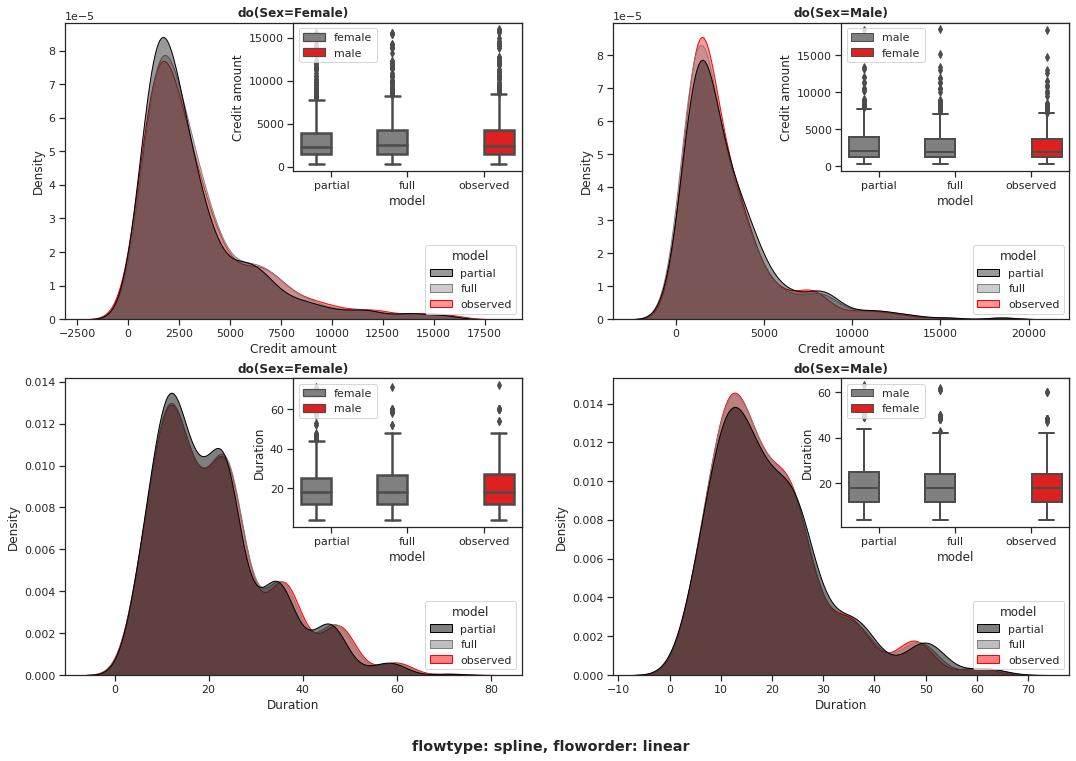

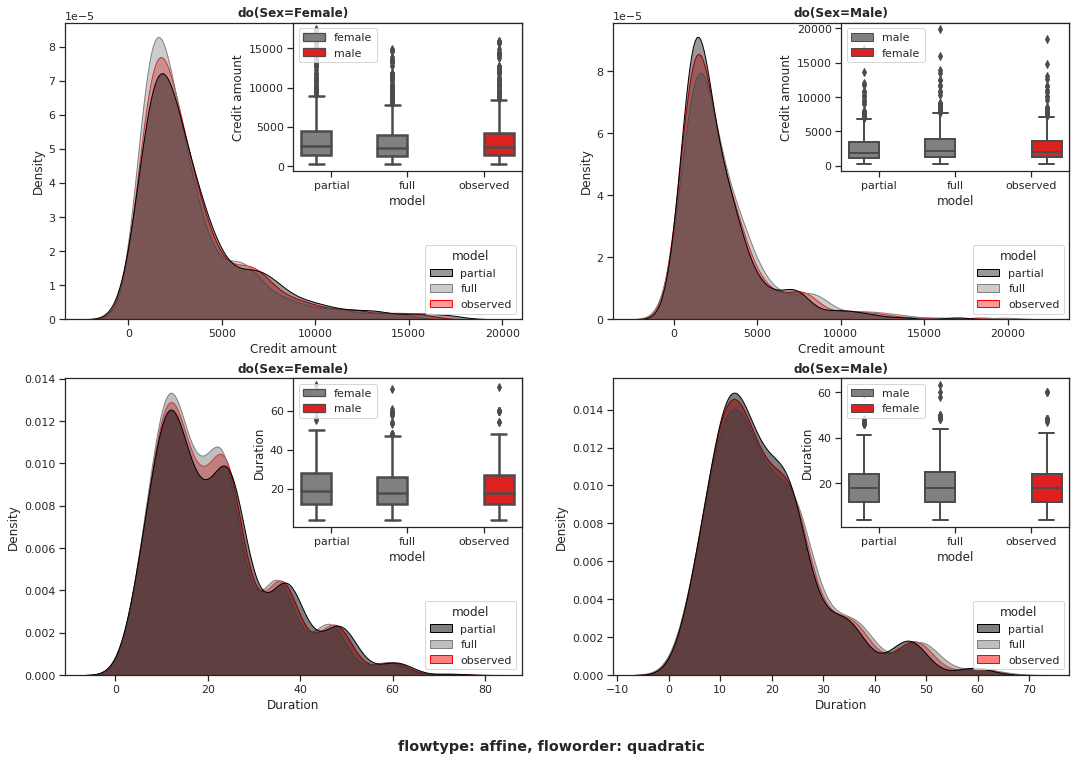

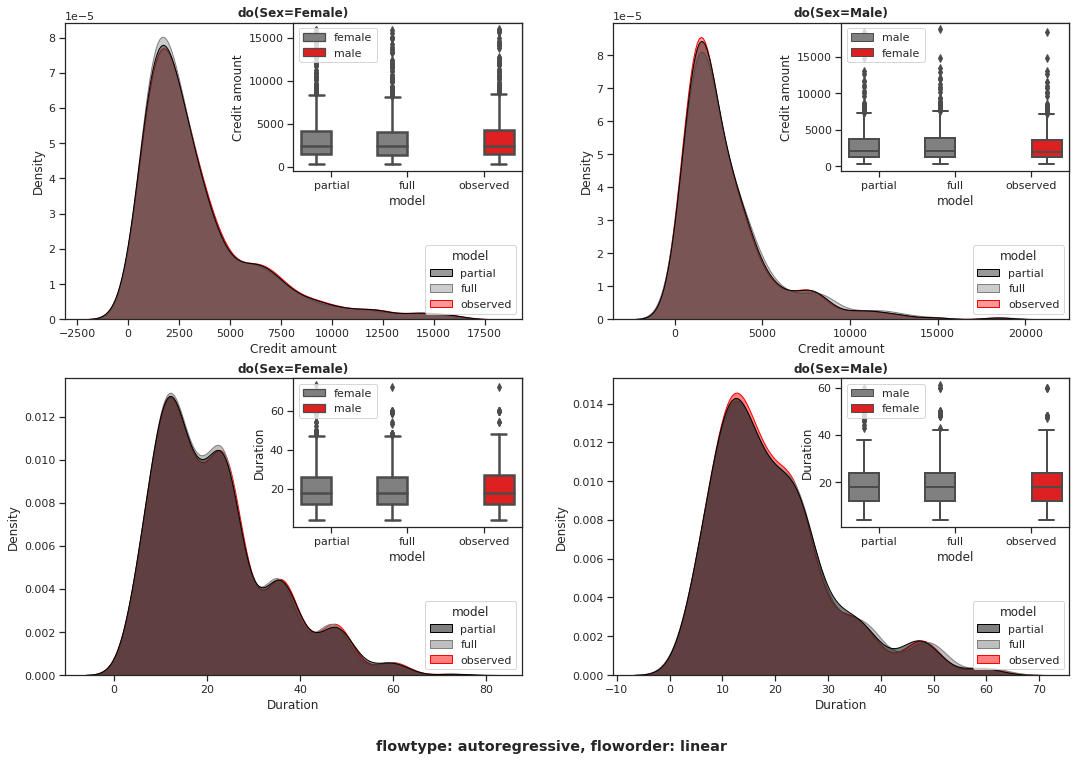

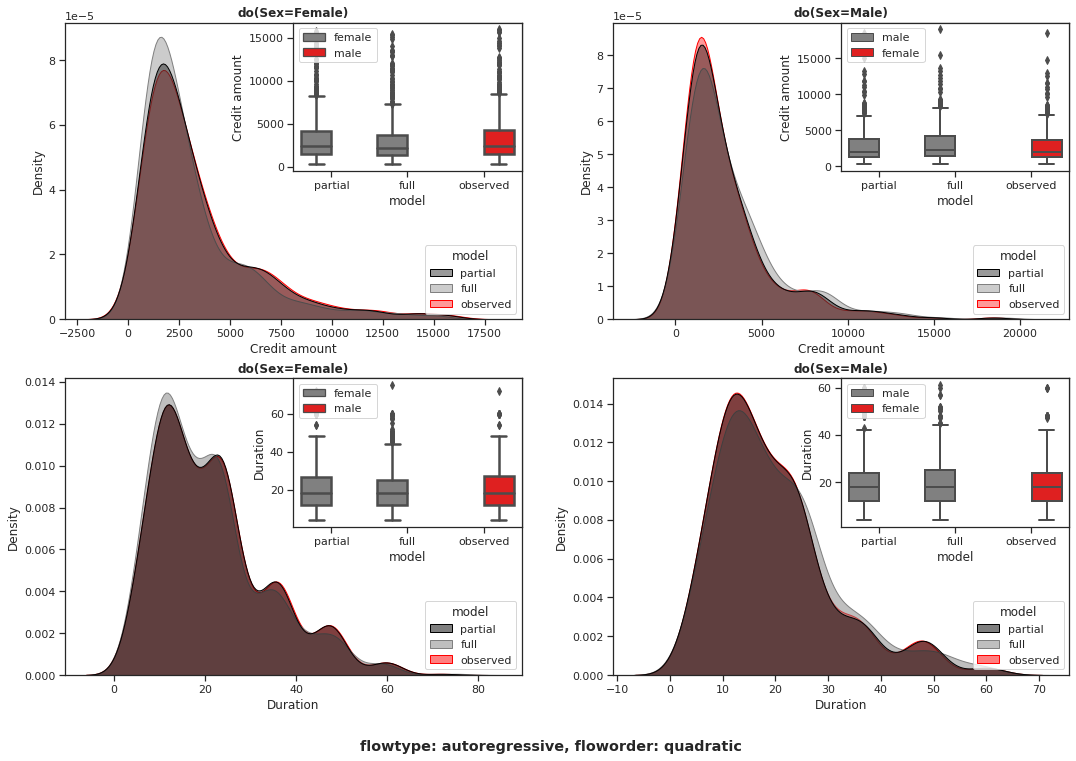

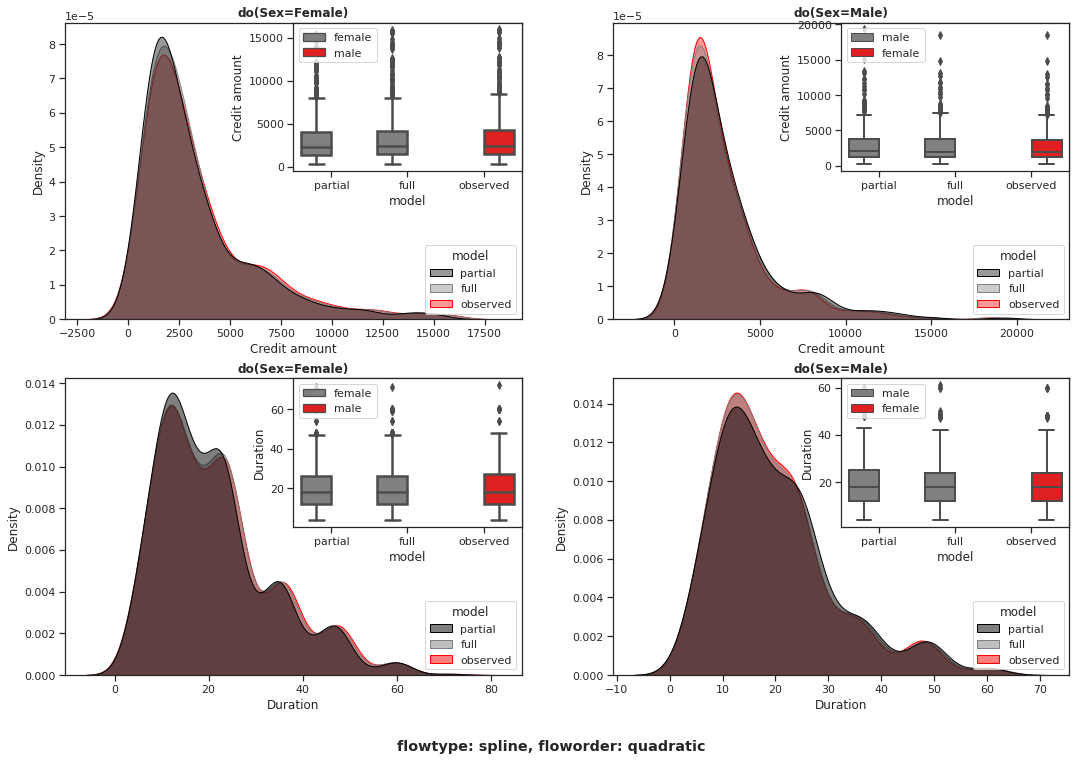

In [4]:
for pair in flow_combinations:
    save_png(plot_function(pair))

### Trial
-----